In [1]:
import xarray as xr
import numpy as np
import os
import pandas as pd
from matplotlib import pyplot as plt
from scipy import interpolate
import cartopy.crs as ccrs
import datetime as dt
import gdal

gdal.UseExceptions()

%matplotlib inline

# Set plot fonts to a larger size
plt.rcParams.update({'font.size': 12})

---
#### Analysis:


Import pickled LST time series for Tuolumne:

In [2]:
modis = pd.read_pickle("../pkl/tuolumne-gaylor-pit.pkl")

In [3]:
modis.head()

,index,datetime,temperature,viewangle,temp_min,temp_max,temp_mean
0,0,2017-03-31 23:35:00,-4.79,41.5,-4.79,-4.79,-4.79
1,1,2017-04-01 03:50:00,NaN,nan,NaN,NaN,NaN
2,2,2017-04-01 13:15:00,5.97,38.0,5.97,5.97,5.97
3,3,2017-04-01 14:50:00,5.57,23.0,5.57,5.57,5.57
4,4,2017-04-02 00:15:00,-3.01,31.5,-3.01,-3.01,-3.01


Get rid of any rows with nan temperatures for now:

In [4]:
modis = modis[~modis.temperature.isnull()]

In [5]:
modis.head()

,index,datetime,temperature,viewangle,temp_min,temp_max,temp_mean
0,0,2017-03-31 23:35:00,-4.79,41.5,-4.79,-4.79,-4.79
2,2,2017-04-01 13:15:00,5.97,38.0,5.97,5.97,5.97
3,3,2017-04-01 14:50:00,5.57,23.0,5.57,5.57,5.57
4,4,2017-04-02 00:15:00,-3.01,31.5,-3.01,-3.01,-3.01
8,8,2017-04-02 23:20:00,-4.93,54.0,-4.93,-4.93,-4.93


Load Gaylor Pit snow surface temperature data

In [6]:
# Gaylor Pit surface temperature data
filepath = r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\MountainGOES\GaylorPit\GaylorPit2017_039_T15min.csv'
gaylor = pd.read_csv(filepath)

# Make some data type and unit conversions
gaylor['datetime'] = pd.to_datetime(gaylor['TIMESTAMP']) # timestamp string to pandas datetime
gaylor['Judd_Air_TempC'] = (gaylor['Judd_Air_TempF'] - 32) / 1.8 # temperature F to temperature C
gaylor['Judd_Depth_cm'] = gaylor['Judd_Depth_in'] * 2.54 # snowdepth inches to snowdepth cm


Load GOES-16 brightness temperature timeseries:

In [36]:
g16_z = pd.read_pickle('..\GOES_B14_BrightnessTemperature_19-22_Feb_2017_GaylorPit_z.pkl') # w/ parallax correction
g16 = pd.read_pickle('..\GOES_B14_BrightnessTemperature_19-22_Feb_2017_GaylorPit.pkl')# w/o parallax correction

In [37]:
# Convert UTC time to local time (UTC-7)
g16_z['time_utc-7'] = g16.time - dt.timedelta(hours=7)
g16['time_utc-7'] = g16.time - dt.timedelta(hours=7)

In [34]:
g16.head()

,time,tb,time_utc-7
0,2017-04-19 00:02:22.145529024,-12.908020,2017-04-18 17:02:22.145529024
1,2017-04-19 00:07:22.145105024,-11.231293,2017-04-18 17:07:22.145105024
2,2017-04-19 00:12:22.144677056,-9.545197,2017-04-18 17:12:22.144677056
3,2017-04-19 00:17:22.146082048,-9.017181,2017-04-18 17:17:22.146082048
4,2017-04-19 00:22:22.145686016,-9.341766,2017-04-18 17:22:22.145686016


***
#### Plot a timeline of MODIS LST and Gaylor Pit temperature data together

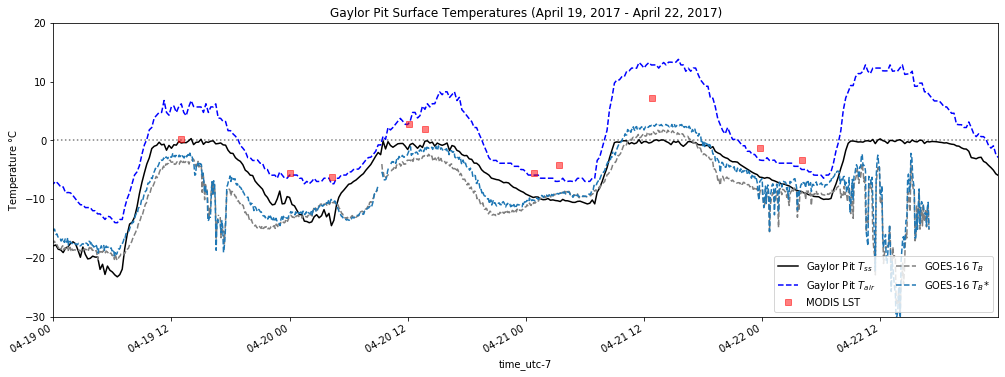

In [40]:
starttime = pd.to_datetime('2017-04-19 00:00')
endtime = pd.to_datetime('2017-04-22 23:59:59')

fig, ax = plt.subplots(figsize=(15,6))

plt.plot([starttime, endtime],[0, 0],':',c='tab:grey')

gaylor.plot(x='datetime',y='TT_C', color='k', ax=ax, label= 'Gaylor Pit $T_{ss}$')
gaylor.plot(x='datetime',y='Judd_Air_TempC', linestyle='--', color='b', ax=ax, label= 'Gaylor Pit $T_{air}$')

modis.plot(x='datetime',y='temperature',
           marker='s',c='r',linestyle='None',ax=ax,
           label='MODIS LST',alpha=0.5)

g16.plot(x='time_utc-7',y='tb',
         c='tab:grey', linestyle='--',ax=ax,
         label='GOES-16 $T_B$')

g16_z.plot(x='time_utc-7',y='tb',
         c='tab:blue', linestyle='--',ax=ax,
         label='GOES-16 $T_B$*')

#aster_time = pd.to_datetime('2017-04-21 11:51:07')
#aster_LST = 8.55
#plt.plot(aster_time,aster_LST,'v',color='k',markersize=10,label='ASTER LST')

#plt.errorbar(modis.datetime,modis.temp_mean,
#             yerr=np.array((modis.temp_max-modis.temp_min)/2),
#             linestyle='None',c='r',linewidth=1.5,
#             label='{}x{} MODIS LST Range'.format((m*2)+1,(m*2)+1))
#

plt.subplots_adjust(right=1)
plt.legend(loc='lower right',ncol=2) #bbox_to_anchor=(0.0, -0.05)
ax.set_xlim((starttime,endtime))
ax.set_ylim((-30,20))
ax.set_ylabel('Temperature $\degree$C');
ax.set_title('Gaylor Pit Surface Temperatures ({} - {})'.format(starttime.strftime("%B %d, %Y"),endtime.strftime("%B %d, %Y")));
plt.savefig('GaylorPit-MODIS-ASTER-LST-timeline.png',dpi=300)

***
Function for finding times from two timeseries that are nearest each other:

In [66]:
def nearest(items, pivot):
    #https://stackoverflow.com/questions/32237862/find-the-closest-date-to-a-given-date
    return min(items, key=lambda x: abs(x - pivot))

***
#### Compare GOES and Gaylor Pit

First, find the GOES observations closest in time to the Gaylor Pit data (GOES-16 was sampling at 5 minute intervals, Gaylor Pit in situ data is at 15 minute intervals).

In [79]:
# Compute the difference in temperatures (GOES - Gaylor Pit)
delta_tair = []
delta_tsnow = []
gaylor_tair = []
gaylor_tsnow = []
goes_tb = []

times = (gaylor.datetime > np.min(g16_z['time_utc-7'])) & (gaylor.datetime < np.max(g16_z['time_utc-7']))
for t in gaylor.datetime[times]:
    goes_time = (nearest(g16_z['time_utc-7'],t))
    tb = g16_z.tb[g16_z['time_utc-7'] == goes_time].values[0]
    goes_tb.append(tb)
    
    tsnow = gaylor['TT_C'][gaylor['datetime']==t].values[0]
    gaylor_tsnow.append(tsnow)
    tair = gaylor['Judd_Air_TempC'][gaylor['datetime']==t].values[0]
    gaylor_tair.append(tair)
    
    delta_tsnow.append(tb - tsnow)
    delta_tair.append(tb - tair)
    

#### Compare GOES-16 Brightness Temperature with in situ snow and air temperatures:

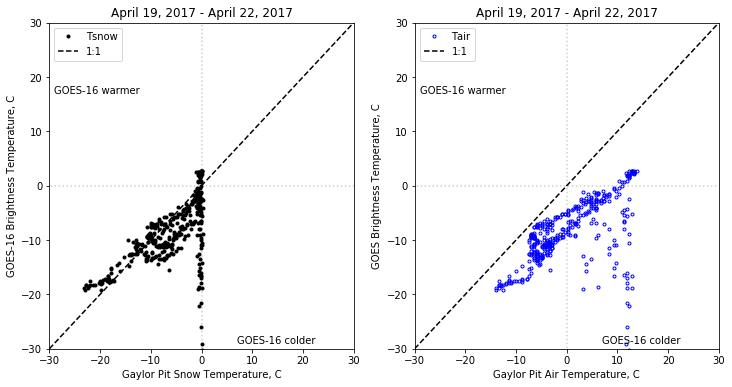

In [84]:
f, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].plot(gaylor_tsnow,goes_tb,'.k',label='Tsnow')
ax[0].plot([-30,30],[-30,30],'--',c='k',label='1:1')
ax[0].plot([0,0],[-100,100],':',c='k',alpha=0.2)
ax[0].plot([-100,100],[0,0],':',c='k',alpha=0.2)
ax[0].set_xlabel('Gaylor Pit Snow Temperature, C')
ax[0].set_ylabel('GOES-16 Brightness Temperature, C')
ax[0].set_xlim((-30,30))
ax[0].set_ylim((-30,30))
ax[0].set_title('{} - {}'.format(starttime.strftime("%B %d, %Y"),endtime.strftime("%B %d, %Y")))
ax[0].legend()
ax[0].text(7,-29,'GOES-16 colder')
ax[0].text(-29,17,'GOES-16 warmer')

ax[1].plot(gaylor_tair,goes_tb,'.',markeredgecolor='b',markerfacecolor='None',label='Tair')
ax[1].plot([-30,30],[-30,30],'--',c='k',label='1:1')
ax[1].plot([0,0],[-100,100],':',c='k',alpha=0.2)
ax[1].plot([-100,100],[0,0],':',c='k',alpha=0.2)
ax[1].set_xlabel('Gaylor Pit Air Temperature, C')
ax[1].set_ylabel('GOES Brightness Temperature, C')
ax[1].set_xlim((-30,30))
ax[1].set_ylim((-30,30))
ax[1].set_title('{} - {}'.format(starttime.strftime("%B %d, %Y"),endtime.strftime("%B %d, %Y")))
ax[1].legend()
ax[1].text(7,-29,'GOES-16 colder')
ax[1].text(-29,17,'GOES-16 warmer')

plt.savefig('GaylorPit-vs-GOES-16-LST.png',dpi=300)

#### How does the difference between GOES-16 Brightness Temperature and ground data change as a function of time?

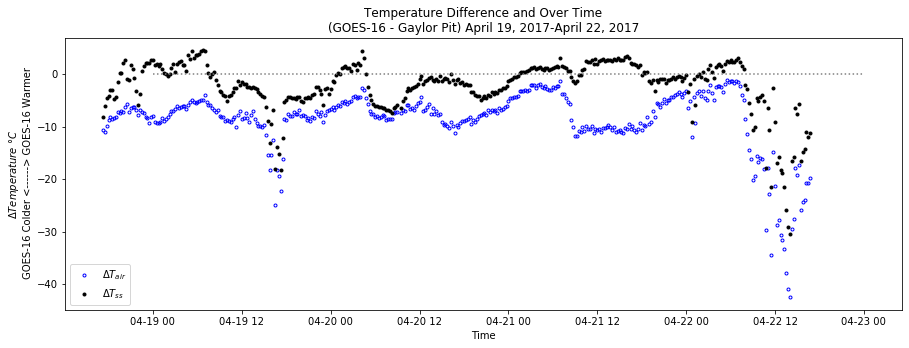

In [83]:
plt.figure(figsize=(15,5))
plt.plot(gaylor.datetime[times],delta_tair,'.',markeredgecolor='b',markerfacecolor='None',label='$\Delta T_{air}$',alpha=1);
plt.plot(gaylor.datetime[times],delta_tsnow,'.k',label='$\Delta T_{ss}$',alpha=1);

plt.xlabel('Time')
plt.ylabel('$\Delta Temperature \,\, \degree C$\n GOES-16 Colder <------> GOES-16 Warmer')
plt.legend()
plt.plot([starttime, endtime],[0, 0],':',c='tab:grey')
plt.title('Temperature Difference and Over Time\n(GOES-16 - Gaylor Pit) {}-{}'.format(starttime.strftime("%B %d, %Y"),endtime.strftime("%B %d, %Y")));
plt.savefig('GaylorPit-GOES-16-deltaLST-timeline.png',dpi=300)

#### How does the difference between GOES-16 Tb and ground data change as a function of hour of day?

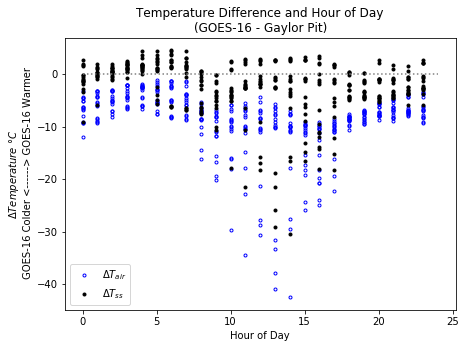

In [82]:
plt.figure(figsize=(7,5))

plt.plot(pd.DatetimeIndex(gaylor.datetime[times]).hour,delta_tair,'.',markeredgecolor='b',markerfacecolor='None',label='$\Delta T_{air}$',alpha=1);
plt.plot(pd.DatetimeIndex(gaylor.datetime[times]).hour,delta_tsnow,'.k',label='$\Delta T_{ss}$',alpha=1);

plt.xlabel('Hour of Day')
plt.ylabel('$\Delta Temperature \,\, \degree C$\n GOES-16 Colder <------> GOES-16 Warmer')
plt.legend()
plt.plot([0, 24],[0, 0],':',c='tab:grey')
plt.title('Temperature Difference and Hour of Day\n(GOES-16 - Gaylor Pit)');

plt.savefig('GaylorPit-GOES-16-deltaLST-hour-of-day.png',dpi=300)

***
#### Compare MODIS and Gaylor Pit


Find the Gaylor Pit observations closest in time to our MODIS data, compute the difference between MODIS LST and Gaylor Pit Tsnow and Tair
Then plot MODIS LST vs Gaylor Pit Tsnow and Tair to see how they compare...

In [42]:
# Compute the difference in temperatures (MODIS - Gaylor Pit)
delta_tair = []
delta_tsnow = []
gaylor_tair = []
gaylor_tsnow = []

i = 0
for time in modis['datetime']:
    gaylor_time = (nearest(gaylor['datetime'],time))
    #print('MODIS Time:{} \t Gaylor Time:{}'.format(time,gaylor_time))
    gaylor_tsnow.append(gaylor['TT_C'][gaylor['datetime']==gaylor_time].values[0])
    gaylor_tair.append(gaylor['Judd_Air_TempC'][gaylor['datetime']==gaylor_time].values[0])
    modis_t = modis.temperature[modis['datetime']==time].values[0]
    #modis_tmin = modis.temp_min[modis['datetime']==time].values[0]
    #modis_tmax = modis.temp_max[modis['datetime']==time].values[0]
    #print('{} \t {} \t {}'.format(modis_t,gaylor_tsnow,gaylor_tair))
    delta_tsnow.append(modis_t - gaylor_tsnow[i])
    delta_tair.append(modis_t - gaylor_tair[i])
    i+=1


#### Compare MODIS LST with in situ snow and air temperatures:

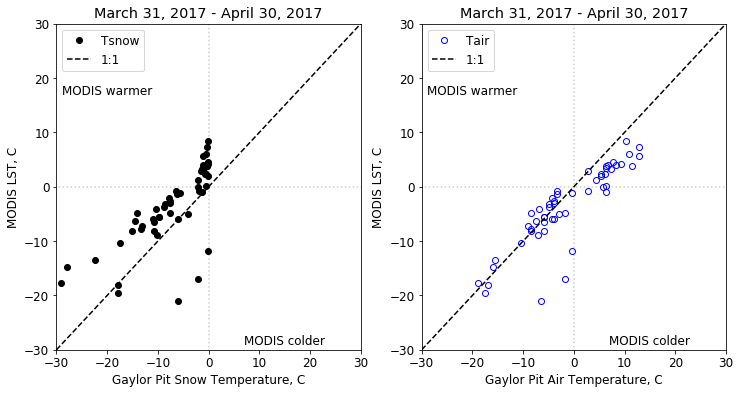

In [66]:
f, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].plot(gaylor_tsnow,modis.temperature,'ok',label='Tsnow')
ax[0].plot([-30,30],[-30,30],'--',c='k',label='1:1')
ax[0].plot([0,0],[-100,100],':',c='k',alpha=0.2)
ax[0].plot([-100,100],[0,0],':',c='k',alpha=0.2)
ax[0].set_xlabel('Gaylor Pit Snow Temperature, C')
ax[0].set_ylabel('MODIS LST, C')
ax[0].set_xlim((-30,30))
ax[0].set_ylim((-30,30))
ax[0].set_title('{} - {}'.format(starttime.strftime("%B %d, %Y"),endtime.strftime("%B %d, %Y")))
ax[0].legend()
ax[0].text(7,-29,'MODIS colder')
ax[0].text(-29,17,'MODIS warmer')

ax[1].plot(gaylor_tair,modis.temperature,'o',markeredgecolor='b',markerfacecolor='None',label='Tair')
ax[1].plot([-30,30],[-30,30],'--',c='k',label='1:1')
ax[1].plot([0,0],[-100,100],':',c='k',alpha=0.2)
ax[1].plot([-100,100],[0,0],':',c='k',alpha=0.2)
ax[1].set_xlabel('Gaylor Pit Air Temperature, C')
ax[1].set_ylabel('MODIS LST, C')
ax[1].set_xlim((-30,30))
ax[1].set_ylim((-30,30))
ax[1].set_title('{} - {}'.format(starttime.strftime("%B %d, %Y"),endtime.strftime("%B %d, %Y")))
ax[1].legend()
ax[1].text(7,-29,'MODIS colder')
ax[1].text(-29,17,'MODIS warmer')

plt.savefig('GaylorPit-vs-MODIS-LST.png',dpi=300)

#### How does the difference between MODIS LST and ground data change as a function of time?

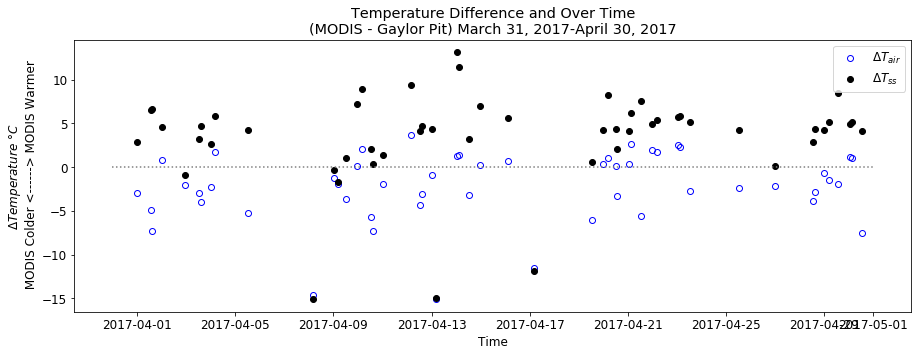

In [65]:
plt.figure(figsize=(15,5))
plt.plot(modis.datetime,delta_tair,'o',markeredgecolor='b',markerfacecolor='None',label='$\Delta T_{air}$',alpha=1);
plt.plot(modis.datetime,delta_tsnow,'ok',label='$\Delta T_{ss}$',alpha=1);

plt.xlabel('Time')
plt.ylabel('$\Delta Temperature \,\, \degree C$\n MODIS Colder <------> MODIS Warmer')
plt.legend()
plt.plot([starttime, endtime],[0, 0],':',c='tab:grey')
plt.title('Temperature Difference and Over Time\n(MODIS - Gaylor Pit) {}-{}'.format(starttime.strftime("%B %d, %Y"),endtime.strftime("%B %d, %Y")));
plt.savefig('GaylorPit-MODIS-deltaLST-timeline.png',dpi=300)

#### How does the difference between MODIS LST and ground data change as a function of hour of day?

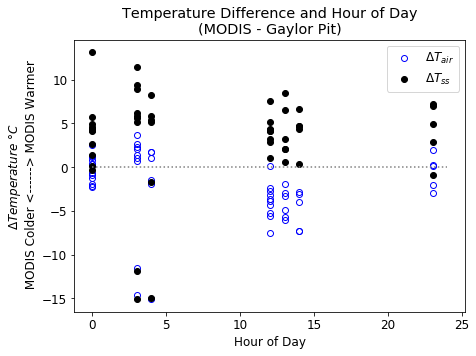

In [72]:
plt.figure(figsize=(7,5))

plt.plot(pd.DatetimeIndex(modis.datetime).hour,delta_tair,'o',markeredgecolor='b',markerfacecolor='None',label='$\Delta T_{air}$',alpha=1);
plt.plot(pd.DatetimeIndex(modis.datetime).hour,delta_tsnow,'ok',label='$\Delta T_{ss}$',alpha=1);

plt.xlabel('Hour of Day')
plt.ylabel('$\Delta Temperature \,\, \degree C$\n MODIS Colder <------> MODIS Warmer')
plt.legend()
plt.plot([0, 24],[0, 0],':',c='tab:grey')
plt.title('Temperature Difference and Hour of Day\n(MODIS - Gaylor Pit)');

plt.savefig('GaylorPit-MODIS-deltaLST-hour-of-day.png',dpi=300)

#### How does the difference between MODIS LST and ground data change as a function of view angle?

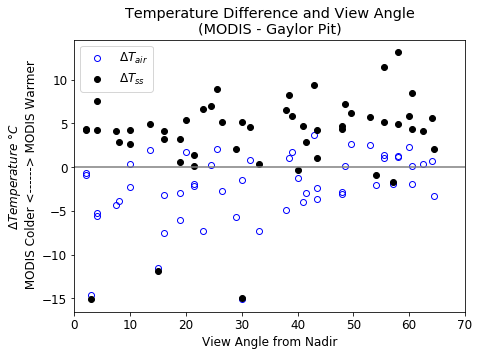

In [71]:
plt.figure(figsize=(7,5))

plt.plot(modis.viewangle,delta_tair,'o',markeredgecolor='b',markerfacecolor='None',label='$\Delta T_{air}$',alpha=1);
plt.plot(modis['viewangle'],delta_tsnow,'ok',label='$\Delta T_{ss}$',alpha=1);

plt.xlabel('View Angle from Nadir')
plt.ylabel('$\Delta Temperature \,\, \degree C$\n MODIS Colder <------> MODIS Warmer')
plt.legend()
plt.xlim([0,70])
plt.plot([0, 70],[0, 0],'-',c='tab:grey')
plt.title('Temperature Difference and View Angle\n(MODIS - Gaylor Pit)');

plt.savefig('GaylorPit-MODIS-deltaLST-view-angle.png',dpi=300)

If we assume a weighted mean between tforest (guessing that it can be represented here by tair) and tsnow, figure out what those weights are here.

In other words:

MODIS LST = ( (1-n) * Tforest + n * Tsnow )

where 1-n is the forest fraction of the pixel, and n is the snow fraction of the pixel

Therefore solving for n:

n = (MODIS LST - Tforest) / (Tsnow - Tforest)

In [ ]:
snow_fraction = []
for i in range(0,len(modis.temperature)):
    snow_fraction.append(( modis.temperature[i] - gaylor_tair[i] ) / (gaylor_tsnow[i] - gaylor_tair[i]))


In [ ]:
plt.plot(modis['viewangle'],snow_fraction,'.k');
plt.xlabel('View Angle from Nadir')
plt.ylabel('Estimated Visible Snow Fraction')
plt.xlim([0,70])
plt.ylim([-1,1])
plt.plot([0, 70],[0, 0],'-',c='tab:grey')
plt.title('Estimated Visible Snow Fraction and View Angle');

# Where snow fraction is < 0, MODIS LST is higher than Tair

#plt.savefig('GaylorPit-MODIS-fsca-test.png',dpi=300)

What's the spread between Tsnow and Tair over time?

In [ ]:
starttime = pd.to_datetime('2017-04-09 00:00')
endtime = pd.to_datetime('2017-04-30 23:59:59')

fig, ax = plt.subplots(figsize=(20,6))

plt.plot([starttime, endtime],[0, 0],':',c='tab:grey')

plt.plot(gaylor.datetime,gaylor.Judd_Air_TempC-gaylor.TT_C, color='r', label= 'Gaylor Pit $T_{air}$ - $T_{ss}$')
gaylor.plot(x='datetime',y='TT_C', color='k', ax=ax, label= 'Gaylor Pit $T_{ss}$')
gaylor.plot(x='datetime',y='Judd_Air_TempC', linestyle='--', color='b', ax=ax, label= 'Gaylor Pit $T_{air}$')
modis.plot(x='datetime',y='temperature',
           marker='s',c='r',linestyle='None',ax=ax,
           label='MODIS LST',alpha=0.5)
plt.legend()
ax.set_xlim((starttime,endtime))
ax.set_ylim((-40,20))
ax.set_ylabel('Temperature $\degree$C');
ax.set_title('Gaylor Pit Air-Snow Surface Temperatures');
plt.savefig('Gaylor Pit Air-Snow Surface Temperatures.png',dpi=300)